# Fostasting Moving Average using ARIMA model

## Data Cleaning
---
Before we start to build the ARIMA model and forecast the moving average, we need to wrangle our data and make it suitable for our purposes.

In [1]:
# load modules
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 999)

In [2]:
# load data and convert date to datetime
rw = pd.read_csv('..//Datasets/NEW/rw_with_airports.csv', parse_dates=['date'])

rw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96074 entries, 0 to 96073
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tail_number            96074 non-null  object        
 1   date                   96074 non-null  datetime64[ns]
 2   aircraft               90671 non-null  object        
 3   origin_code            96074 non-null  object        
 4   origin                 96074 non-null  object        
 5   destination_code       96074 non-null  object        
 6   destination            96074 non-null  object        
 7   departure              96074 non-null  object        
 8   arrival                96074 non-null  object        
 9   duration               96074 non-null  int64         
 10  distance_mi            96074 non-null  float64       
 11  Owner                  96074 non-null  object        
 12  origin_Latitude        96074 non-null  float64       
 13  o

In [3]:
rw.head()

,tail_number,date,aircraft,origin_code,origin,destination_code,destination,departure,arrival,duration,distance_mi,Owner,origin_Latitude,origin_Longitude,destination_Latitude,destination_Longitude,airport_origin,city_origin,origin_state,country_origin,airport_destination,city_destination,destination_state,country_destination,departure_shift,arrival_shift
0,N640EC,2021-03-11,EC35,KPGV,Pitt-Greenville (KPGV),KRWI,Rocky Mount-Wilson Rgnl (KRWI),04:29AM EST,04:46AM EST,16,32.296705,"METRO AVIATION INCSHREVEPORT, LA, US(Corporation)",35.635201,-77.385300,35.856300,-77.891899,Pitt Greenville Airport,Greenville,NC,US,Rocky Mount Wilson Regional Airport,Rocky Mount,NC,US,night,night
1,N640EC,2021-03-11,EC35,KRWI,Rocky Mount-Wilson Rgnl (KRWI),KPGV,Pitt-Greenville (KPGV),02:17AM EST,03:47AM EST,89,32.296705,"METRO AVIATION INCSHREVEPORT, LA, US(Corporation)",35.856300,-77.891899,35.635201,-77.385300,Rocky Mount Wilson Regional Airport,Rocky Mount,NC,US,Pitt Greenville Airport,Greenville,NC,US,night,night
2,N640EC,2021-03-11,EC35,KPGV,Pitt-Greenville (KPGV),KRWI,Rocky Mount-Wilson Rgnl (KRWI),01:15AM EST,01:30AM EST,15,32.296705,"METRO AVIATION INCSHREVEPORT, LA, US(Corporation)",35.635201,-77.385300,35.856300,-77.891899,Pitt Greenville Airport,Greenville,NC,US,Rocky Mount Wilson Regional Airport,Rocky Mount,NC,US,night,night
3,N640EC,2021-03-10,EC35,KIXA,"Roanoke Rapids, NC",KPGV,Pitt-Greenville (KPGV),11:33PM EST,12:02AM EST,28,54.850847,"METRO AVIATION INCSHREVEPORT, LA, US(Corporation)",36.403840,-77.637860,35.635201,-77.385300,Halifax-Northampton Regional Airport,Roanoke Rapids,NC,US,Pitt Greenville Airport,Greenville,NC,US,night,night
4,N640EC,2021-03-10,EC35,KRWI,Rocky Mount-Wilson Rgnl (KRWI),KIXA,"Roanoke Rapids, NC",08:50PM EST,09:31PM EST,41,41.163189,"METRO AVIATION INCSHREVEPORT, LA, US(Corporation)",35.856300,-77.891899,36.413910,-77.628940,Rocky Mount Wilson Regional Airport,Rocky Mount,NC,US,Halifax-Northampton Regional Airport,Roanoke Rapids,NC,US,night,night


In [4]:
# Check for null values
rw.isna().sum()

tail_number                 0
date                        0
aircraft                 5403
origin_code                 0
origin                      0
destination_code            0
destination                 0
departure                   0
arrival                     0
duration                    0
distance_mi                 0
Owner                       0
origin_Latitude             0
origin_Longitude            0
destination_Latitude        0
destination_Longitude       0
airport_origin              0
city_origin                63
origin_state               40
country_origin              0
airport_destination         0
city_destination            0
destination_state          23
country_destination         0
departure_shift             0
arrival_shift               0
dtype: int64

In [5]:
# drop rows with null arrival and duration because we consider that flights as diverted or canceled
rw = rw.dropna(subset=['arrival'])
rw = rw.dropna(subset =['duration'])

In [6]:
rw.shape

(96074, 26)

In our dataset, we also have flights with the same origin and destination locations. After some investigation, we assume that these flights were training. Hence, drop these records too.  

In [7]:
rw.shape

(21959, 26)

Now, when the dataset is cleaned from unnecessary flights, let's group it by day and count the number of same days. Why we counted days? It is because the number of the same days represents the number of flights for this day. For instance, if aircraft made 5 flights in one day then the data will contain the 5 same days for this aircraft with the different time, of course, and so on. 

In [7]:
# count number of flights for each day and asign a new dataset
fl_num = pd.DataFrame(rw.date.value_counts().sort_index()).rename({'date':'Flights_num'}, axis=1)
fl_num

,Flights_num
2020-11-29,270
2020-11-30,660
2020-12-01,951
2020-12-02,1015
2020-12-03,1054
...,...
2021-03-07,1341
2021-03-08,1395
2021-03-09,1277
2021-03-10,1201


According to the table above, you can see the 2020-11-29, 2021-03-11, 2021-03-12 dates have a much lower number of flights. This is because of restricted access to the data and, hence, the data is incomplete for that dates. Thus, we need to drop them. Eventually, our final date range is between 2020-11-30 and 2021-03-10 (102 days).

In [8]:
# As you can see the 2020-11-29, 2021-03-11, 2021-03-12 dates are much lower. This is because we have incomplete data for these days. Thus, we need to drop them.
fl_num = fl_num.loc["2020-11-30":'2021-03-10']
fl_num

,Flights_num
2020-11-30,660
2020-12-01,951
2020-12-02,1015
2020-12-03,1054
2020-12-04,904
...,...
2021-03-06,1375
2021-03-07,1341
2021-03-08,1395
2021-03-09,1277


Now let's add the moving average for this date range with the 30-day rolling window and plot a graph.

In [9]:
# Add a moving Average for 30 days window to see trend
fl_num['Moving_average'] = fl_num['Flights_num'].rolling(window='30D').mean()

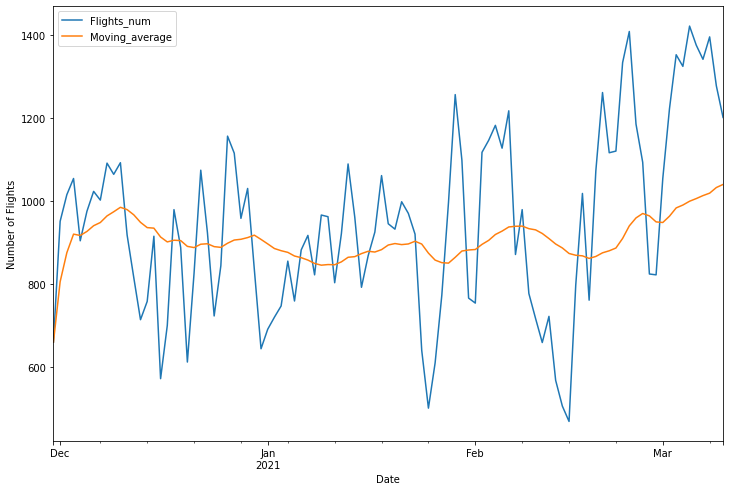

In [11]:
# Plot and show the time series
fig, ax = plt.subplots(figsize=(12,8))
fl_num.plot(ax=ax)
plt.xlabel("Date")
plt.ylabel("Number of Flights")
#plt.savefig('rw_num_flights.jpeg')
plt.show()

## Data preprocessing and validation for modeling
Split the data into a train and test set for 75/25 proportion. A splitting point at this proportion is 14Feb2021.

In [12]:
# Split the data into a train and test set
fl_num_train = fl_num.loc[:"2021-02-14"]
fl_num_test = fl_num.loc['2021-02-14':]

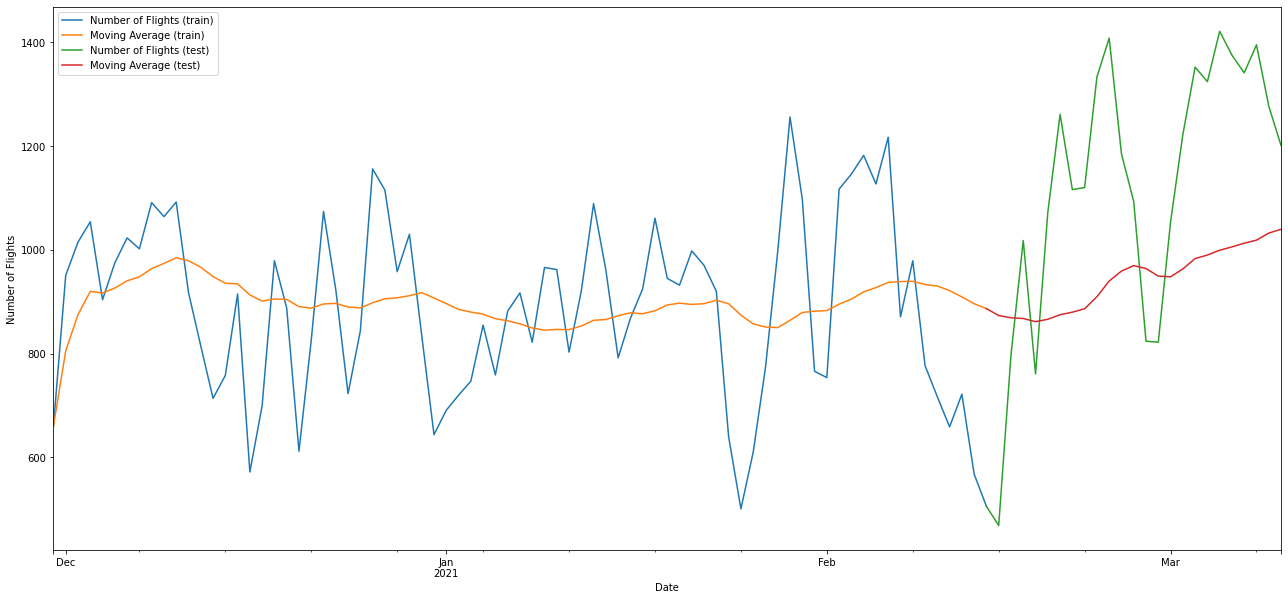

In [13]:
# Create an axis
fig, ax = plt.subplots(figsize=(22,10))

# Plot the train and test sets on the axis ax
fl_num_train.plot(ax=ax)
fl_num_test.plot(ax=ax)
plt.legend(['Number of Flights (train)', 'Moving Average (train)', 'Number of Flights (test)', 'Moving Average (test)'])
plt.xlabel("Date")
plt.ylabel("Number of Flights")
#plt.savefig('rw_num_flights_splitted.jpeg')
plt.show()

### The augmented Dicky-Fuller test
Our dataset visually looks stationary. But, we can perform non-stationarity Hypothesis Testing. The most common test for identifying whether a time series is non-stationary is the augmented Dicky-Fuller test. This is a statistical test, where the null hypothesis is that your time series is non-stationary due to the trend.

In [14]:
# Run the augmented Dicky-Fuller to test for stationarity 
result = adfuller(fl_num_train.Flights_num)

# Print test statistic
print("test statistic: ", round(result[0],2))

# Print p-value
print("p-value: ", result[1],5)

test statistic:  -3.17
p-value:  0.021480664836825158 5


According to the test results, we reject a null hypothesis that our data is non-stationary. Thus, we don't require any transformations.

### Choosing the model

__What model to choose?__

How do we choose which ARIMA model to fit? AR, MA, or both? The model order is very important to the quality of forecasts. One of the main ways to identify the correct model order is by using the autocorrelation function, the ACF, and the partial autocorrelation function the PACF.

__What is the ACF__

The autocorrelation function at lag-1 is the correlation between a time series and the same time series offset by one step. The autocorrelation at lag-2 is the correlation between a time series and itself offset by two steps. And so on. When we talk about the autocorrelation function we mean the set of correlation values for different lags. We can plot the autocorrelation function to get an overview of the data. The bars show and ACF values at increasing lags. If these values are small and lie inside the blue shaded region, then they are not statistically significant.

__What is the PACF__

The partial autocorrelation is the correlation between a time series and the lagged version of itself after we subtract the effect of correlation at smaller lags. So it is the correlation associated with just that particular lag. The partial autocorrelation function is this series of values and we can plot it to get another view of the data.

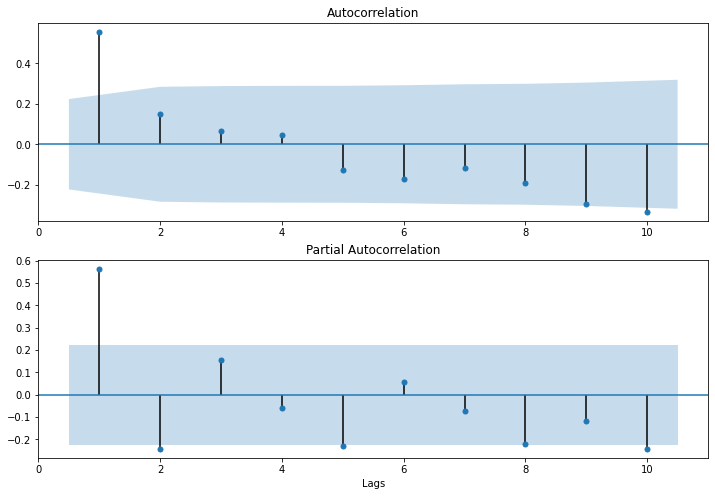

In [15]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of fl_num_train
plot_acf(fl_num_train.Flights_num, lags=10, zero=False, ax=ax1)

# Plot the PACF of fl_num_train
plot_pacf(fl_num_train.Flights_num, lags=10, zero=False, ax=ax2)

plt.xlabel("Lags")
#plt.savefig('ACF_PACF.jpeg')
plt.show()

__Plots interpretaions__

By comparing the ACF and PACF for a time series we can deduce the model order. If the amplitude of the ACF tails off with increasing lag and the PACF cuts off after some lag p, then we have an AR(p) model. If the amplitude of the ACF cuts off after some lag q and the amplitude of the PACF tails off then we have a MA(q) model. If both the ACF and PACF tail off then we have an ARMA model. In this case, we can't deduce the model orders of p and q from the plot. 

In our graph both cut off after ACF lag-1 and PACF lag-1. It identifies that it might be either AR(1), MA(1), or ARMA(1,1) model. 

What would happen if we transform our data:

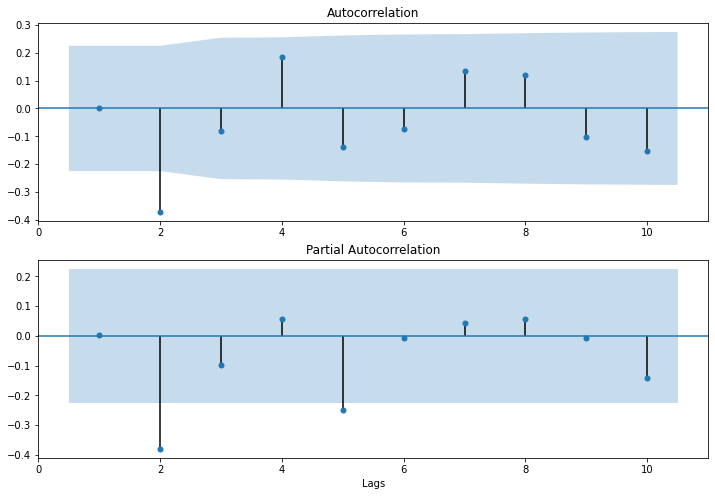

In [16]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of fl_num_train
plot_acf(fl_num_train.Flights_num.diff().dropna(), lags=10, zero=False, ax=ax1)

# Plot the PACF of fl_num_train
plot_pacf(fl_num_train.Flights_num.diff().dropna(), lags=10, zero=False, ax=ax2)

plt.xlabel("Lags")
#plt.savefig('ACF_PACF.jpeg')
plt.show()

If the autocorrelation at lag-1 is very negative this is a sign that we have taken the difference too many times.

### Model evaluation through AIC and BIC
ACF and PACF can't be used to choose the order of a model, when both of the orders p and q are non-zero. However there are more tools we can use, the AIC and the BIC. For both of these metrics, a lower value suggests a better model. The difference between these two metrics is how much they penalize model complexity. The BIC penalizes additional model orders more than AIC and so the BIC will sometimes suggest a simpler model. The AIC and BIC will often choose the same model, but when they don't we will have to make a choice. If our goal is to identify good predictive models, we should use AIC. However, if our goal is to identify a good explanatory model, we should use BIC.

In [17]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(3):
    # Loop over q values from 0-2
    for q in range(3):
        try:
            # create and fit ARMA(p,q) model
            model = SARIMAX(fl_num_train.Flights_num, order=(p,0,q), trend='t')
            results = model.fit()
            
            # Append order and results tuple
            order_aic_bic.append((p,q, results.aic, results.bic))
            
        except:
            order_aic_bic.append((p,q, None, None))

In [18]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
order_df.sort_values('AIC').head()

,p,q,AIC,BIC
8,2,2,989.442398,1003.505231
5,1,2,998.659251,1010.378278
3,1,0,1004.967300,1011.998716
4,1,1,1006.759447,1016.134669
6,2,0,1006.917576,1016.292798


In [19]:
# Print order_df in order of increasing BIC
order_df.sort_values('BIC').head()

,p,q,AIC,BIC
8,2,2,989.442398,1003.505231
5,1,2,998.659251,1010.378278
3,1,0,1004.967300,1011.998716
4,1,1,1006.759447,1016.134669
6,2,0,1006.917576,1016.292798


Both metrics show that ARMA(1,1) is a better model. Now, when we decided which model to use, let's forecast. 

## Forecasting

In [20]:
# Create ARMA(1,0) model
arma = SARIMAX(fl_num_train.Flights_num, order=(2,0,2), trend='t')

# Fit model
results = arma.fit()

### Model diagnostics

In [21]:
# Print fit summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:            Flights_num   No. Observations:                   77
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -488.721
Date:                Mon, 26 Apr 2021   AIC                            989.442
Time:                        20:58:49   BIC                           1003.505
Sample:                    11-30-2020   HQIC                           995.067
                         - 02-14-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0004      0.028      0.013      0.990      -0.054       0.055
ar.L1          1.3747   1.16e-05   1.18e+05      0.000       1.375       1.375
ar.L2         -0.3747   3.75e-05  -9988.521      0.0

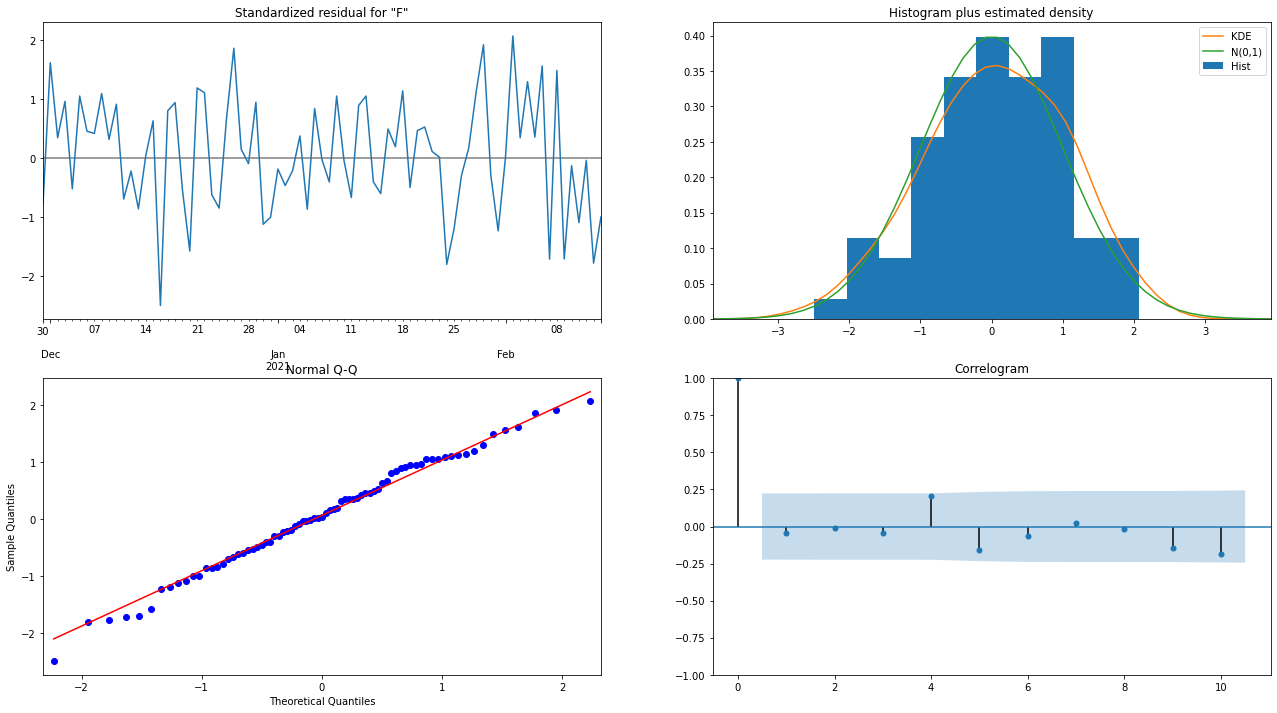

In [23]:
results.plot_diagnostics(figsize=(22,12))
#plt.savefig('model_diagnostics.jpeg')
plt.show()

### Forecasting in of sample
Let's test our model by making predictions in-sample train dataset. In the time period, we have data for, we can make lots of these predictions in-sample; using the previous series value to estimate the next ones. This is called a __one-step-ahead prediction__. This allows us to evaluate how good our model is at predicting just one value. Here, the mean prediction is marked with a red line while the uncertainty range is shaded (yellow). The uncertainty is due to the random shock terms that we can't predict.

We set the start parameter as a negative integer stating how many steps back to begin the forecast. Setting start to -20 means we make predictions for the last 20 entries of the training data.  

In [24]:
# Generate predictions
one_step_forecast = results.get_prediction(start = -20)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Flights_num']
upper_limits = confidence_intervals.loc[:,'upper Flights_num']

# Print estimate  predictions
mean_forecast.head()

2021-01-26     651.525177
2021-01-27     748.204389
2021-01-28     839.622103
2021-01-29     986.156613
2021-01-30    1138.749777
Freq: D, Name: predicted_mean, dtype: float64

This returns a forecast object. The central value of the forecast is stored in the <code>predicted_mean</code> attribute of the forecast object. This predicted mean is a pandas series.

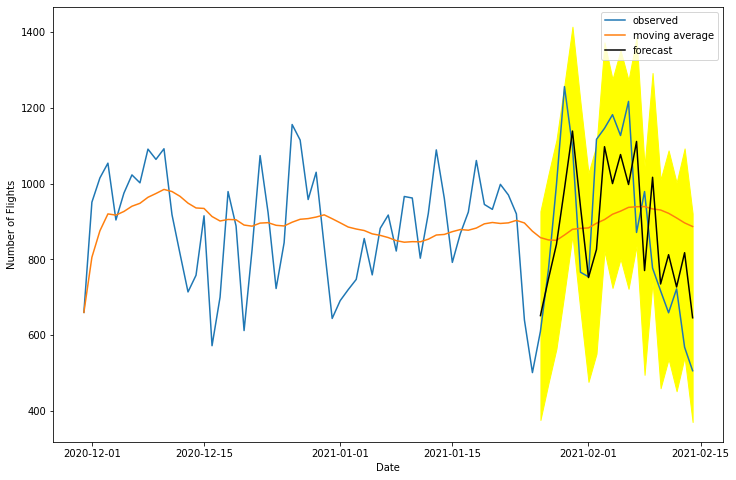

In [25]:
# plot the data
plt.figure(figsize=(12,8))
plt.plot(fl_num_train.index, fl_num_train)

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='black')

# shade the area between your confidence limits
plt.fill_between(mean_forecast.index, lower_limits,
		 upper_limits, color='yellow')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.legend(['observed', 'moving average', 'forecast'])
#plt.savefig('pred_in_samp.jpeg')
plt.show()

### Dynamic predictions
We can make predictions further than just one step ahead. To make these dynamic predictions we predict one step, and use this predicted value to forecast the next value after that ... and so on. Since we don't know the shock term at each step, our uncertainty can grow very quickly. Making dynamic predictions is very similar to making one-step-ahead predictions. The only difference is that in the <code>get_predictions</code> method, we set the parameter dynamic equals to true. Everything else is exactly as before.

In [26]:
# Generate predictions
dynamic_forecast = results.get_prediction(start=-20, dynamic=True)

# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Flights_num']
upper_limits = confidence_intervals.loc[:,'upper Flights_num']

# Print estimate predictions
mean_forecast.head()

2021-01-26    651.525177
2021-01-27    783.235235
2021-01-28    832.610155
2021-01-29    851.132785
2021-01-30    858.094792
Freq: D, Name: predicted_mean, dtype: float64

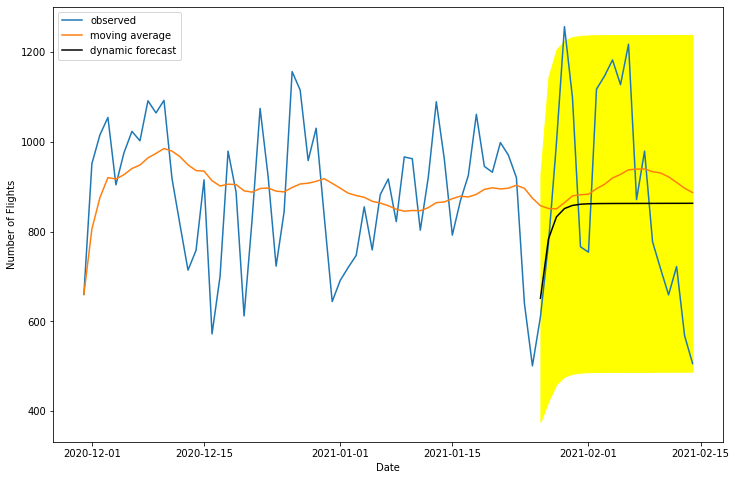

In [29]:
# plot the data
plt.figure(figsize=(12,8))
plt.plot(fl_num_train.index, fl_num_train)

# plot your mean forecast
plt.plot(mean_forecast.index, mean_forecast, color='black')

# shade the area between your confidence limits
plt.fill_between(mean_forecast.index, lower_limits, 
         upper_limits, color='yellow')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.legend(loc="upper left", labels=['observed', 'moving average', 'dynamic forecast'])
#plt.savefig('pred_in_samp_dyn.jpeg')
plt.show()

### Forecasting out of sample
Finally, after testing our predictions in-sample, we can use our model to predict the future. To make future forecasts we use the <code>get_forecast</code> method of the results object. We choose the number of steps after the end of the training data to forecast up to. We will forecast dynamic predictions for the next 25 days. This the date range of our test dataset. To sum up, we will plot together train, test, and predicted MA data. Then we'll compare and evaluate how accurate our model is predicted.

In [30]:
# Make ARIMA forecast of next 25 values
arima_value_forecast = results.get_forecast(steps=25).predicted_mean

# Print forecast
arima_value_forecast.head()

2021-02-15    670.027844
2021-02-16    794.621600
2021-02-17    841.336968
2021-02-18    858.870081
2021-02-19    865.468366
Freq: D, Name: predicted_mean, dtype: float64

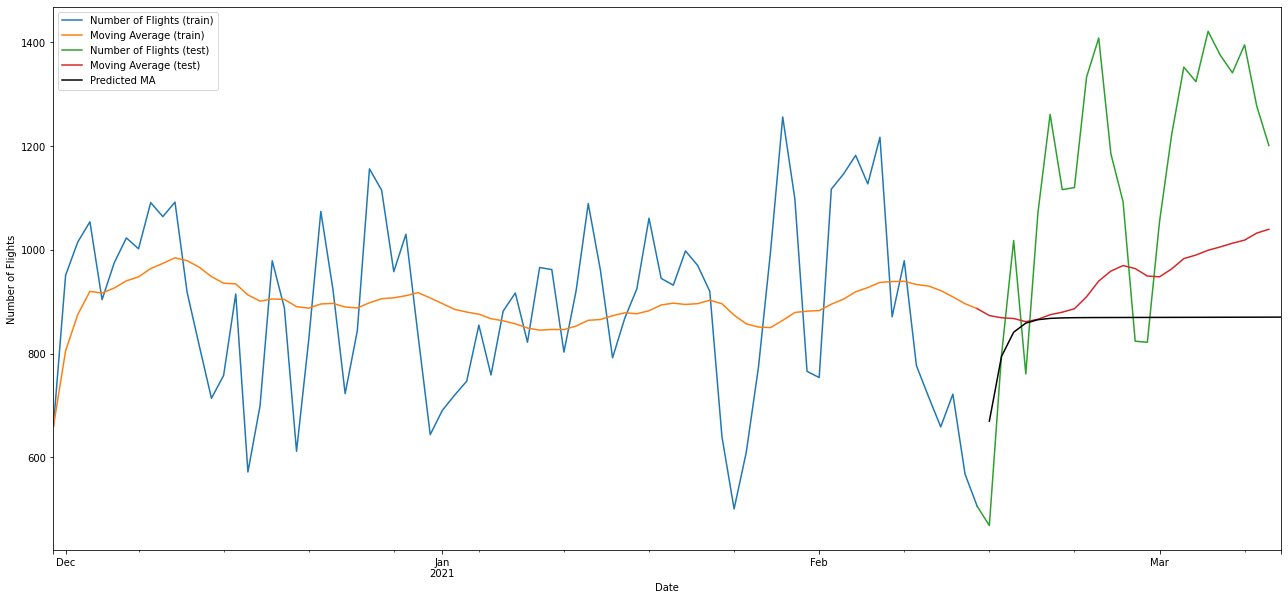

In [32]:
# Create an axis
fig, ax = plt.subplots(figsize=(22,10))

# Plot the train, test , and forecasted values on the axis ax
fl_num_train.plot(ax=ax)
fl_num_test.plot(ax=ax)
arima_value_forecast.plot(ax=ax, color='black')
plt.legend(['Number of Flights (train)', 'Moving Average (train)', 
            'Number of Flights (test)', 'Moving Average (test)', 'Predicted MA'])
plt.xlabel('Date')
plt.ylabel('Number of Flights')
#plt.savefig('pred_test.jpeg')
plt.show()

A Black line on the graph represents a predicted moving average by our model for the next 25 days. A red line is a real moving average of the test dataset. Visually, it seems that our model predicted a moving average not bad. Nevertheless, it's difficult to evaluate the accuracy of prediction by the graph.       